# **Diagonal preconditioning**

One of the simplest choices for the preconditioner $M$ is a diagonal matrix. This definitely meets the requirement of being fast to invert: the solution of $Mv =y$ is just $v_i = y_i/M_ii$ The only question is whether it can be chosen in such a way that $M^{-1}A$ is much more amenable to krylov iterations than $A$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import random
from scipy.sparse.linalg import spilu, LinearOperator

In [4]:
seed = 42

def get_diagonal_dominant_matrix(n, low=-10, high=10):
    """Generate a random n x n diagonally dominant matrix."""
    np.random.seed(seed)
    A = np.random.randint(low, high, size=(n, n)).astype(float)
    for i in range(n):
        A[i, i] = sum(np.abs(A[i])) + 10  # Ensure diagonal dominance
    return A

N = 500
A = get_diagonal_dominant_matrix(N)
x_true = np.random.randint(-10, 10, size=N).astype(float)
b = A @ x_true

# print("Matrix A:")
# print(A)
# print("x_true =", x_true)
# print("b =", b)


In [5]:
def gmres(A, b, m):
    """
    gmres(A, b, m)

    Do m iterations of GMRES for the linear system A*x=b. Return the final solution
    estimate x and a vector with the history of residual norms. (This function is for
    demo only, not practical use.)
    """
    n = len(b)
    Q = np.zeros([n, m + 1])
    Q[:, 0] = b / np.linalg.norm(b)
    H = np.zeros([m + 1, m])

    # Initial "solution" is zero.
    residual = np.hstack([np.linalg.norm(b), np.zeros(m)])

    for j in range(m):
        # Next step of Arnoldi iteration.
        v = A @ Q[:, j]
        for i in range(j + 1):
            H[i, j] = Q[:, i] @ v
            v -= H[i, j] * Q[:, i]
        H[j + 1, j] = np.linalg.norm(v)
        Q[:, j + 1] = v / H[j + 1, j]

        # Solve the minimum residual problem.
        r = np.hstack([np.linalg.norm(b), np.zeros(j + 1)])
        z = np.linalg.lstsq(H[:j + 2, :j + 1], r)[0]
        x = Q[:, :j + 1] @ z
        residual[j + 1] = np.linalg.norm(A @ x - b)

    return x, residual

## Preconditioning Effectiveness

C:\Users\56940\AppData\Local\Temp\ipykernel_8284\2227864861.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  z = np.linalg.lstsq(H[:j + 2, :j + 1], r)[0]


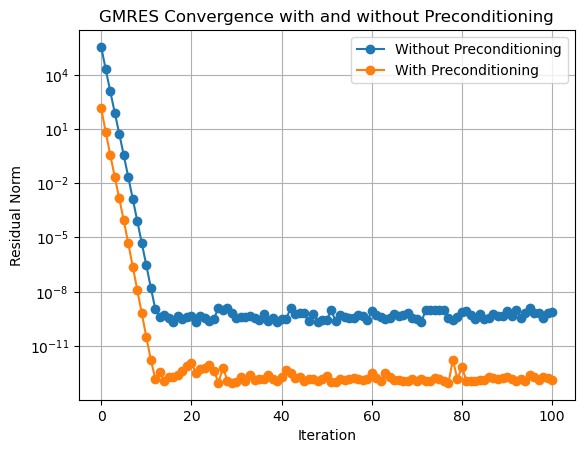

In [9]:
iters = 100
x = np.arange(iters + 1)
_, residuals_without = gmres(A, b, iters)

M_inv = np.diag(1/np.diag(A)) 
A_tilde = M_inv @ A
b_tilde = M_inv @ b
_, residuals_with = gmres(A_tilde, b_tilde, iters)

# plot 
plt.semilogy(x, residuals_without, 'o-', label='Without Preconditioning')
plt.semilogy(x, residuals_with, 'o-', label='With Preconditioning')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('GMRES Convergence with and without Preconditioning')
plt.legend()
plt.grid()
plt.show()





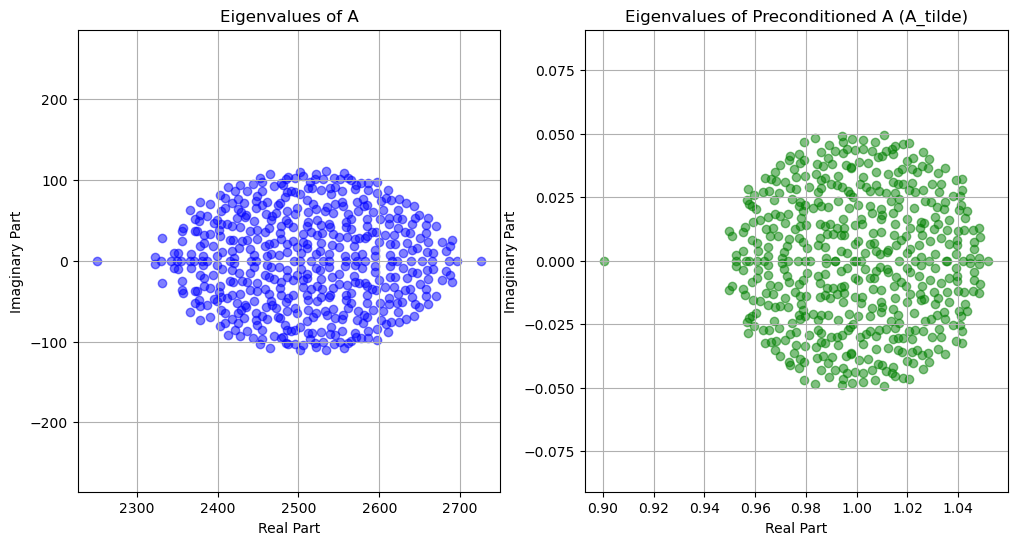

In [10]:
# Plot eigenvalues
eigenvalues_A = np.linalg.eigvals(A)
eigenvalues_A_tilde = np.linalg.eigvals(A_tilde)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(eigenvalues_A.real, eigenvalues_A.imag, color='blue', alpha=0.5)
plt.title('Eigenvalues of A')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid()
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.scatter(eigenvalues_A_tilde.real, eigenvalues_A_tilde.imag, color='green', alpha=0.5)
plt.title('Eigenvalues of Preconditioned A (A_tilde)')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid()
plt.axis('equal')
plt.show()

# LU Preconditioning

In [ ]:
# reproducibilidad
seed = 42
density = 0.3

# Matriz dispersa aleatoria
sparse_matrix = random(N, N, density=density, format='csr', random_state=seed)

print("Matriz sparse (CSR):")
print(sparse_matrix.toarray())

# Factorización ILU incompleta
ilu = spilu(sparse_matrix)
# Construir el precondicionador como LinearOperator
M_inv = LinearOperator(sparse_matrix.shape, ilu.solve)

b_tilde = M_inv @ b
A_tilde = M_inv @ sparse_matrix

print("\nVector original b:", b)
print("Vector transformado M^{-1} b:", b_tilde)
print("\nMatriz original A:")
print(sparse_matrix.toarray())
print("Matriz transformada M^{-1} A:")
print(A_tilde.toarray())
